# Simple BoW + Logistic Regression model

In this notebook we use the simplest approach: build Bag of Words features, and use them to train a Logistic Regression model. Everything is done in Scikit-Learn.

**TODO** complete?

In [1]:
# add scripts/ folder to path
import os, sys

SCRIPTS_PATH = os.environ['DSX_PROJECT_DIR'] + '/scripts'
sys.path.insert(0, SCRIPTS_PATH)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import visualization # custom script

In [3]:
DATASET_PATH = "/user-home/libraries/text-analytics/datasets/aclImdb"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test/"

## 0. Load files

In [4]:
from sklearn.datasets import load_files

In [5]:
reviews_train = load_files(TRAIN_PATH)

**TODO** just load a subset

In [6]:
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'list'>
length of text_train: 25000
text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


In [7]:
reviews_test = load_files(TEST_PATH)

In [8]:
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


Use a subset just for dev: (**TODO** find a way to do this when loading the data directly)

In [9]:
text_train, y_train = text_train[:1000], y_train[:1000]
text_test, y_test = text_test[:1000], y_test[:1000]

## 1. Preprocessing

Even though the preprocessing is short and straightforward, we probably want to move this to a script at some point.

In [10]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [11]:
np.unique(y_train)

array([0, 1])

In [12]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [498 502]


## 2. Feature Engineering

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<1000x17994 sparse matrix of type '<class 'numpy.int64'>'
	with 135356 stored elements in Compressed Sparse Row format>


In [15]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 17994
First 20 features:
['00', '000', '007', '01', '06', '07', '08', '10', '100', '1000', '1000lb', '100mph', '101', '104', '105', '10s', '10star', '10th', '11', '112']
Features 20010 to 20030:
[]
Every 2000th feature:
['00', 'bookish', 'cursing', 'favorites', 'imitated', 'mavis', 'plant', 'scrap', 'tenderness']


## 3. Build model

### 3.1 Simple LogisticRegression, not tuned

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean cross-validation accuracy: 0.79


### 3.2 Grid Search for Logistic Regression

In [17]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.79
Best parameters:  {'C': 0.1}


In [18]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.79


In [19]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.79


In [21]:
model = grid.best_estimator_

### 3.3 Investigating model coefficients

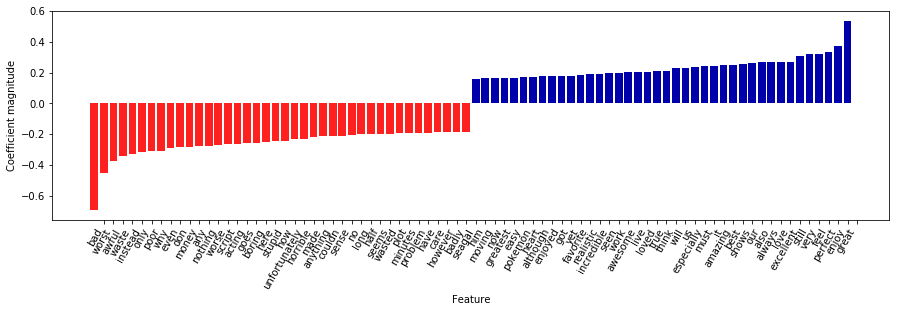

In [22]:
visualization.visualize_coefficients(
    model.coef_,
    feature_names, n_top_features=40)

## 4. Store model

### 4.1 Save model in ML repository

In [23]:
from dsx_ml.ml import save

In [31]:
X_test

<1000x17994 sparse matrix of type '<class 'numpy.int64'>'
	with 125003 stored elements in Compressed Sparse Row format>

In [33]:
save(name='simple-bow',
     model=model,
     x_test=pd.DataFrame(X_test.toarray()),
     y_test=pd.DataFrame(y_test),
     algorithm_type='Classification',
     description='This is the first simple bag of words model with logistic regression.')

{'path': '/user-home/1055/DSX_Projects/text-deployment-demo/models/simple-bow/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/scikit-learn-0.20/text-deployment-demo/simple-bow/1'}

Once this is called, the model shows up in the "models" section of WSL, in version v1.

**TODO put bow in the pipeline so we can save it in the model repo as well**

### 4.2 Test model in Models UI

- Save the notebook and switch to the Models tab of the project.
- Under Models, find and click into your saved model.
- Click the Real-time score link to test the model.

### 4.3 Test model with REST API call

In [34]:
# TODO